Accuracy on training data: 0.8512396694214877
Accuracy on test data: 0.8688524590163934
LIME Explanation:
[('-0.69 < exang <= 1.45', -0.012532345579695453), ('ca > 0.30', -0.009975380436448252), ('fbs <= -0.40', -0.009140866278778276), ('age <= -0.81', 0.0082872315678904), ('slope <= -0.67', -0.0059699082961611576)]


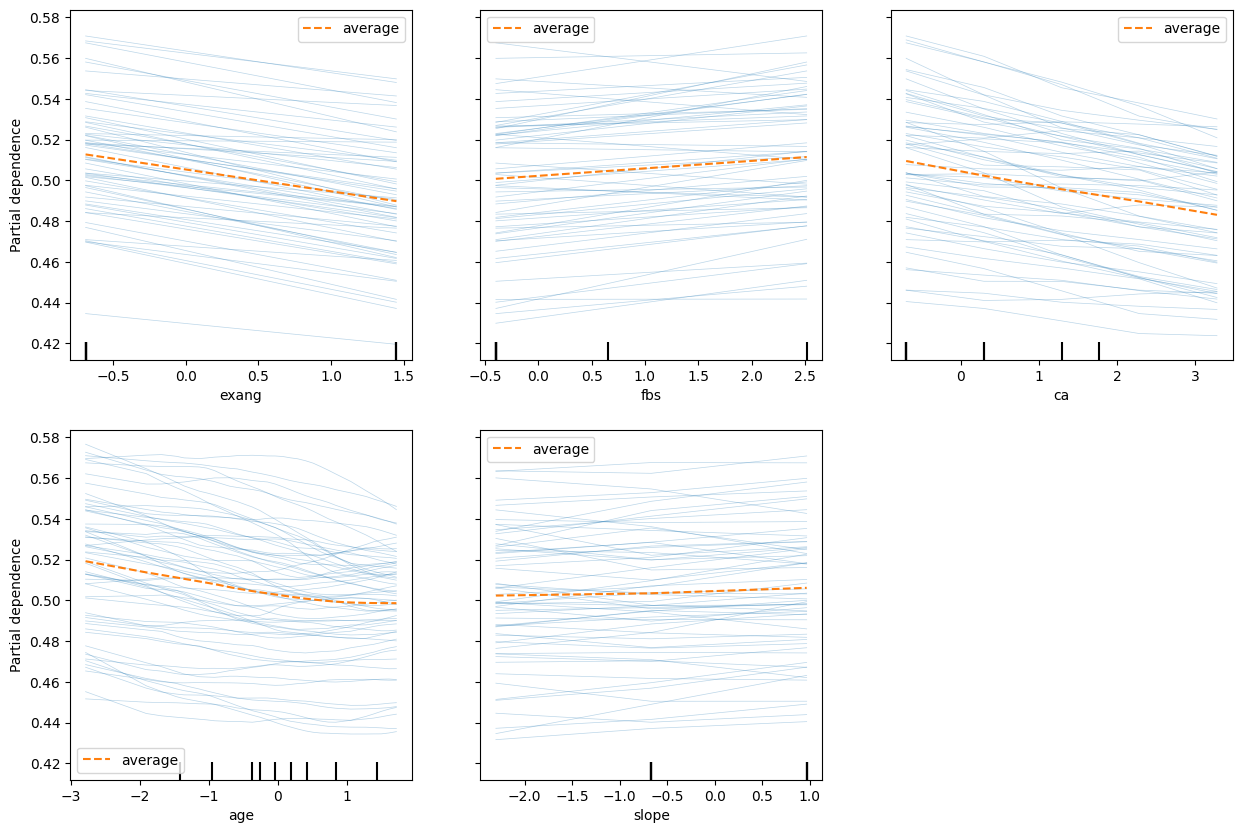

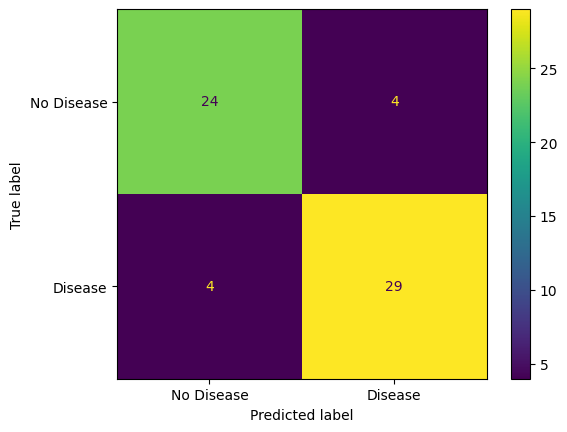

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import lime.lime_tabular
import joblib
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Load the heart disease dataset
heart_data = pd.read_csv(r"C:\Users\Ramachandra\OneDrive\Desktop\6th sem miniproject\heart_disease_data (1).csv")

# Separate features and target variable
X = heart_data.drop(columns='target', axis=1)
y = heart_data['target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the MLP model with more layers and neurons
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(1024, 512, 256, 128),  # Significantly increased number of neurons
    activation='relu',  # Using relu activation function
    alpha=0.0001,  # Regularization strength
    solver='adam',
    learning_rate_init=0.0001,  # Reduced learning rate
    max_iter=5000,  # Increased max iterations
    random_state=2,
    early_stopping=True,
    n_iter_no_change=20,  # Early stopping criterion
    validation_fraction=0.1  # Fraction of training data to set aside for validation
)

# Train the MLP classifier
mlp_classifier.fit(X_train_scaled, y_train)

# Model evaluation using accuracy score
train_accuracy = accuracy_score(y_train, mlp_classifier.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, mlp_classifier.predict(X_test_scaled))

print("Accuracy on training data:", train_accuracy)
print("Accuracy on test data:", test_accuracy)

# Save the best MLP model using joblib
filename = 'best_heart_disease_mlp_model.joblib'
joblib.dump(mlp_classifier, filename)

# Create a LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=X.columns.tolist(), class_names=['No Disease', 'Disease'], discretize_continuous=True, mode='classification')

# Example input data (first instance from the test set)
input_data = X_test_scaled[0].reshape(1, -1)

# Generate explanations for a single instance
exp = explainer.explain_instance(input_data[0], mlp_classifier.predict_proba, num_features=5)

print('LIME Explanation:')
print(exp.as_list())
exp.show_in_notebook()

# PDP and ICE plots using sklearn.inspection
features_to_plot =[8,5,11,0,10] # Indices of features to plot, adjust as necessary

# Plot PDP and ICE for selected features
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(
    mlp_classifier, 
    X_test_scaled, 
    features=features_to_plot, 
    feature_names=X.columns, 
    kind="both",  # plot both PDP and ICE
    ax=ax
)
plt.show()

# Draw confusion matrix
y_pred = mlp_classifier.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
disp.plot()
plt.show()
